# Automatic differentiation


In [1]:
import sympy as sp
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.func import jvp
from torch.func import jacfwd, jacrev

## Symbolic vs Automatic Differentiation

This example compares analytical and automatic differentiation on the same
function. 

### First Derivative
Using `SymPy`, the derivative is computed exactly and then converted
into a numerical callable. Using `PyTorch`, the derivative is obtained through
autograd by creating inputs with gradient tracking and calling `backward()` to
extract the gradient.

Both approaches are evaluated over a uniform grid and plotted together,
highlighting how closely `PyTorch`’s autograd matches the exact derivative
computed with `SymPy`.

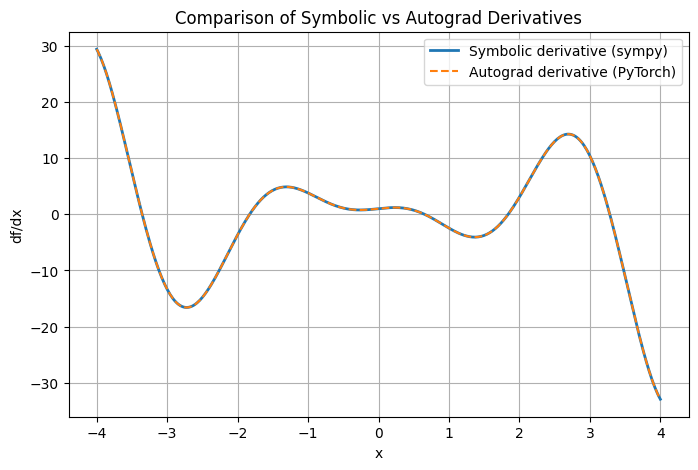

In [2]:
# ---------------------------------------------------------
# 1. Symbolic derivative with sympy
# ---------------------------------------------------------
x = sp.symbols('x')
f_expr = sp.sin(x) * sp.exp(-x/3) + x**2 * sp.cos(2*x)
df_expr = sp.diff(f_expr, x)

# convert sympy expr → numeric function
f_sym = sp.lambdify(x, f_expr, "numpy")
df_sym = sp.lambdify(x, df_expr, "numpy")

# ---------------------------------------------------------
# 2. Autograd derivative with PyTorch
# ---------------------------------------------------------
def f_torch(x):
    return torch.sin(x) * torch.exp(-x/3) + x**2 * torch.cos(2 * x)

def df_torch(x):
    grads = []
    for xv in x:
        xv_t = torch.tensor(xv, dtype=torch.float32, requires_grad=True)
        y = f_torch(xv_t)
        y.backward()
        grads.append(xv_t.grad.item())
    return np.array(grads)

# ---------------------------------------------------------
# 3. Compare on a grid
# ---------------------------------------------------------
xs = np.linspace(-4, 4, 400)
df_sym_vals = df_sym(xs)
df_autograd_vals = df_torch(xs)

# ---------------------------------------------------------
# 4. Plot
# ---------------------------------------------------------
plt.figure(figsize=(8, 5))
plt.plot(xs, df_sym_vals, label="Symbolic derivative (sympy)", linewidth=2)
plt.plot(xs, df_autograd_vals, "--", label="Autograd derivative (PyTorch)")
plt.title("Comparison of Symbolic vs Autograd Derivatives")
plt.xlabel("x")
plt.ylabel("df/dx")
plt.legend()
plt.grid(True)
plt.show()


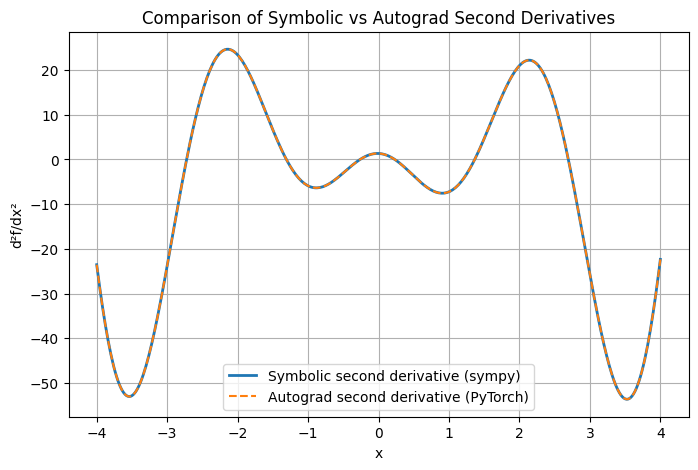

In [3]:
d2f_expr = sp.diff(df_expr, x)

# convert to numpy-callable functions
d2f_sym = sp.lambdify(x, d2f_expr, "numpy")

def d2f_torch(x_values):
    grads2 = []
    for xv in x_values:
        xv_t = torch.tensor(xv, dtype=torch.float32, requires_grad=True)

        # First derivative
        y = f_torch(xv_t)
        dy_dx = torch.autograd.grad(y, xv_t, create_graph=True)[0]

        # Second derivative
        d2y_dx2 = torch.autograd.grad(dy_dx, xv_t)[0]

        grads2.append(d2y_dx2.item())
    return np.array(grads2)

# ---------------------------------------------------------
# 3. Compare on a grid
# ---------------------------------------------------------
xs = np.linspace(-4, 4, 400)
d2f_sym_vals = d2f_sym(xs)
d2f_autograd_vals = d2f_torch(xs)

# ---------------------------------------------------------
# 4. Plot
# ---------------------------------------------------------
plt.figure(figsize=(8, 5))
plt.plot(xs, d2f_sym_vals, label="Symbolic second derivative (sympy)", linewidth=2)
plt.plot(xs, d2f_autograd_vals, "--", label="Autograd second derivative (PyTorch)")
plt.title("Comparison of Symbolic vs Autograd Second Derivatives")
plt.xlabel("x")
plt.ylabel("d²f/dx²")
plt.legend()
plt.grid(True)
plt.show()


### Second Derivative

This example compares two approaches for computing the derivative of the same
function. Using `SymPy`, the derivative is obtained analytically and converted
into a numerical function for fast evaluation. Using `PyTorch`, forward-mode
automatic differentiation is applied via `jvp`, where each input is paired with
a tangent value of `1.0` to produce the forward derivative directly.

Both methods are evaluated on a dense grid and plotted together, illustrating
how forward-mode AD from `PyTorch` aligns with the exact symbolic derivative
computed by `SymPy`.


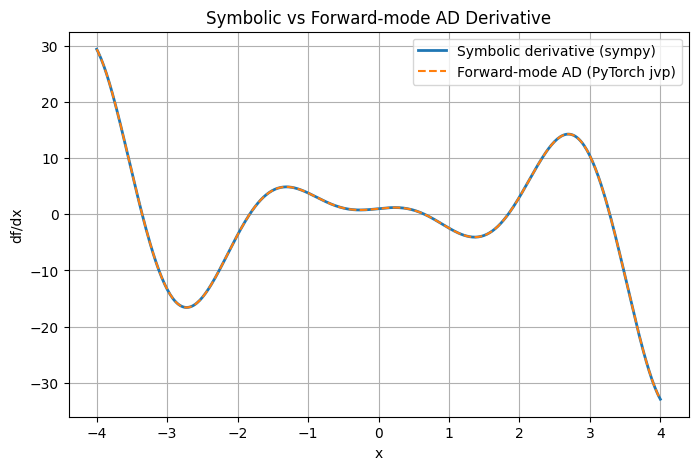

In [4]:
# ---------------------------------------------------------
# 1. Symbolic derivative with sympy
# ---------------------------------------------------------
x = sp.symbols('x')
f_expr = sp.sin(x) * sp.exp(-x/3) + x**2 * sp.cos(2*x)
df_expr = sp.diff(f_expr, x)

df_sym = sp.lambdify(x, df_expr, "numpy")

# ---------------------------------------------------------
# 2. Forward-mode AD with PyTorch (jvp)
# ---------------------------------------------------------
def f_torch(x_t):
    return torch.sin(x_t) * torch.exp(-x_t/3) + x_t**2 * torch.cos(2 * x_t)

def df_forward(x_values):
    grads = []
    for xv in x_values:
        # primal value (x) and tangent (dx/dx = 1)
        primals = (torch.tensor(xv, dtype=torch.float32),)
        tangents = (torch.tensor(1.0, dtype=torch.float32),)

        y, dydx = jvp(f_torch, primals, tangents)
        grads.append(dydx.item())
    return np.array(grads)

# ---------------------------------------------------------
# 3. Compare on a grid
# ---------------------------------------------------------
xs = np.linspace(-4, 4, 400)
df_sym_vals = df_sym(xs)
df_fwd_vals = df_forward(xs)

# ---------------------------------------------------------
# 4. Plot
# ---------------------------------------------------------
plt.figure(figsize=(8, 5))
plt.plot(xs, df_sym_vals, label="Symbolic derivative (sympy)", linewidth=2)
plt.plot(xs, df_fwd_vals, "--", label="Forward-mode AD (PyTorch jvp)")
plt.title("Symbolic vs Forward-mode AD Derivative")
plt.xlabel("x")
plt.ylabel("df/dx")
plt.legend()
plt.grid(True)
plt.show()


## Forward-mode vs Reverse-mode Jacobians

This example computes the Jacobian of a vector-valued function  
$F: \mathbb{R}^3 \to \mathbb{R}^2$ using two automatic-differentiation strategies in `PyTorch`.
Forward-mode (`jacfwd`) propagates tangents from inputs to outputs, making it
efficient when the input dimension is small. Reverse-mode (`jacrev`) propagates
sensitivities from outputs back to inputs, which is advantageous when the output
dimension is small.

Both Jacobians are computed at a single point and compared element-wise. The
results confirm that `jacfwd` and `jacrev` produce the same Jacobian (up to
numerical precision), illustrating the consistency of the two differentiation
modes for this function.


In [5]:
# F: R^3 -> R^2
def F(x):
    # x: shape (3,)
    x0, x1, x2 = x
    y1 = torch.sin(x0) + x1**2
    y2 = torch.exp(x2) - x0 * x1
    return torch.stack([y1, y2])   # shape (2,)

# single input point in R^3
x = torch.tensor([0.3, -1.2, 0.7], dtype=torch.float32)

# Forward-mode Jacobian (jacfwd) and reverse-mode Jacobian (jacrev)
J_fwd = jacfwd(F)(x)   # shape (2, 3)
J_rev = jacrev(F)(x)   # shape (2, 3)

print("J_fwd (forward-mode):")
print(J_fwd)
print("\nJ_rev (reverse-mode):")
print(J_rev)

print("\nMax abs difference:", (J_fwd - J_rev).abs().max().item())
print("Allclose? ->", torch.allclose(J_fwd, J_rev, atol=1e-6))


J_fwd (forward-mode):
tensor([[ 0.9553, -2.4000,  0.0000],
        [ 1.2000, -0.3000,  2.0138]])

J_rev (reverse-mode):
tensor([[ 0.9553, -2.4000,  0.0000],
        [ 1.2000, -0.3000,  2.0138]])

Max abs difference: 0.0
Allclose? -> True


## Manual Forward-mode vs Reverse-mode Jacobian Construction

This example builds the Jacobian of the map $F: \mathbb{R}^3 \to \mathbb{R}^2$ using the underlying
mechanics of forward-mode and reverse-mode automatic differentiation.

Forward-mode constructs the Jacobian **column by column**. Each standard basis
vector in the input space is pushed through `F` via a `jvp`, producing the
directional derivative $J e_j$, which forms column $j$ of the Jacobian.

Reverse-mode constructs the Jacobian **row by row**. Each standard basis vector
in the output space is used as `grad_outputs` in `autograd.grad`, yielding
$e_i^\top J$, which forms row $i$ of the Jacobian.

Both Jacobians are assembled explicitly and compared, showing that forward-mode
and reverse-mode give the same result, differing only by floating-point
precision.


In [6]:
# ---------------------------------------------------------
# Input
# ---------------------------------------------------------
x = torch.tensor([0.3, -1.2, 0.7], dtype=torch.float32, requires_grad=True)

# Dimensions
n = 3       # number of inputs x
m = 2       # number of outputs F(x)

# ---------------------------------------------------------
# FORWARD-MODE: iterate over n input directions (columns)
# ---------------------------------------------------------
J_fwd_cols = []
basis_inputs = torch.eye(n)           # e1, e2, e3

for j in range(n):
    e_j = basis_inputs[j]

    # jvp returns (F(x), J(x)*e_j)
    _, col_j = jvp(F, (x,), (e_j,))
    
    J_fwd_cols.append(col_j)

J_fwd = torch.stack(J_fwd_cols, dim=1)    # shape (m, n)


# ---------------------------------------------------------
# REVERSE-MODE: iterate over m output components (rows)
# ---------------------------------------------------------
J_rev_rows = []
y = F(x)

basis_outputs = torch.eye(m)          # e1, e2

for i in range(m):
    e_i = basis_outputs[i]

    # autograd.grad returns (e_i^T * J(x))
    grad_row_i_ = torch.autograd.grad(
        y,
        x,
        grad_outputs=e_i,
        retain_graph=True,  # ????
    )
    
    print(grad_row_i_)
    
    grad_row_i = grad_row_i_[0]

    J_rev_rows.append(grad_row_i)

J_rev = torch.stack(J_rev_rows, dim=0)    # shape (m, n)


# ---------------------------------------------------------
# Compare the Jacobians
# ---------------------------------------------------------
print("J_fwd (forward-mode, columns):\n", J_fwd)
print("\nJ_rev (reverse-mode, rows):\n", J_rev)
print("\nMax abs diff:", (J_fwd - J_rev).abs().max().item())
print("Allclose? ->", torch.allclose(J_fwd, J_rev, atol=1e-6))


(tensor([ 0.9553, -2.4000,  0.0000]),)
(tensor([ 1.2000, -0.3000,  2.0138]),)
J_fwd (forward-mode, columns):
 tensor([[ 0.9553, -2.4000,  0.0000],
        [ 1.2000, -0.3000,  2.0138]], grad_fn=<StackBackward0>)

J_rev (reverse-mode, rows):
 tensor([[ 0.9553, -2.4000,  0.0000],
        [ 1.2000, -0.3000,  2.0138]])

Max abs diff: 0.0
Allclose? -> True
